In [113]:
import pandas as pd
import numpy as np
import torch
import shap
import seaborn as sns
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt

import os 
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [114]:
X, y = shap.datasets.california(n_points=1000)
train_x, test_x, train_y, test_y = train_test_split(X, y, 
                                                    test_size = 0.2, random_state = 42)

In [115]:
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.fit_transform(test_x)

In [135]:
early_stop = EarlyStopping(patience=20, restore_best_weights=True)

cal_model = tf.keras.Sequential([
    tf.keras.Input(shape=(train_x_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Specify the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compiling the model
cal_model.compile(optimizer=optimizer, loss="mean_squared_error")

# Training the model
train_model = cal_model.fit(x=train_x_scaled, y=train_y, batch_size=32, epochs=500,
                            callbacks=[early_stop], validation_split= 0.2)

Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.1988 - val_loss: 2.2006
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7104 - val_loss: 1.1798
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8593 - val_loss: 0.8830
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5856 - val_loss: 0.7709
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4835 - val_loss: 0.7302
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5594 - val_loss: 0.6848
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4534 - val_loss: 0.6212
Epoch 8/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3864 - val_loss: 0.6001
Epoch 9/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3766 - val_loss: 0.5709
Epoch 10/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3240 - val_loss: 0.5426
Epoch 11/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2913 - val_loss: 0.5567
Epoch 12/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [136]:
#evaluating on train data

train_loss = cal_model.evaluate(train_x_scaled, train_y)
print(f"Train Loss: {train_loss:.4f}")

cal_model_train_probs = cal_model.predict(train_x_scaled)
cal_model_train_preds = cal_model_train_probs.flatten()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1255 
Train Loss: 0.1817
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [137]:
mse = mean_squared_error(train_y, cal_model_train_preds)
mae = mean_absolute_error(train_y, cal_model_train_preds)
r2 = r2_score(train_y, cal_model_train_preds)

print(f"MSE: {mse: .3f}, MAE: {mae: .3f}, R² Score: {r2: .3f}")

MSE:  0.182, MAE:  0.294, R² Score:  0.866


In [138]:
#evaluating on test data

test_loss = cal_model.evaluate(test_x_scaled, test_y)
print(f"Test Loss: {test_loss:.4f}")

cal_model_test_probs = cal_model.predict(test_x_scaled)
cal_model_test_preds = cal_model_train_probs.flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4297 
Test Loss: 0.4146
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [140]:
mse = mean_squared_error(test_y, cal_model_test_probs)
mae = mean_absolute_error(test_y, cal_model_test_probs)
r2 = r2_score(test_y, cal_model_test_probs)

print(f"MSE: {mse: .3f}, MAE: {mae: .3f}, R² Score: {r2: .3f}")

MSE:  0.415, MAE:  0.465, R² Score:  0.729


In [154]:
#Using the SHAP deep explainer on the neural net

data_subset, _ = train_test_split(train_x_scaled, test_size=0.875, random_state=42)
train_sample = data_subset.astype(np.float32)
#train_sample = train_x_scaled[:100].astype(np.float32)
test_sample = test_x_scaled[:10].astype(np.float32)

explainer = shap.DeepExplainer(cal_model, train_sample)
shap_values = explainer.shap_values(test_sample)

#reshaping shap to match test_sample
shap_values_squeezed = shap_values.squeeze()

c:\Users\uramac\miniconda3\envs\behavioral-data-science\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\uramac\miniconda3\envs\behavioral-data-science\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_91
Received: inputs=['Tensor(shape=(100, 8))']
  warnings.warn(msg)
c:\Users\uramac\miniconda3\envs\behavioral-data-science\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_91
Received: inputs=['Tensor(shape=(200, 8))']
  warnings.warn(msg)
c:\Users\uramac\miniconda3\envs\behavioral-data-science\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The struct

C:\Users\uramac\AppData\Local\Temp\ipykernel_18716\3381420979.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_squeezed, test_sample, feature_names=feature_names)


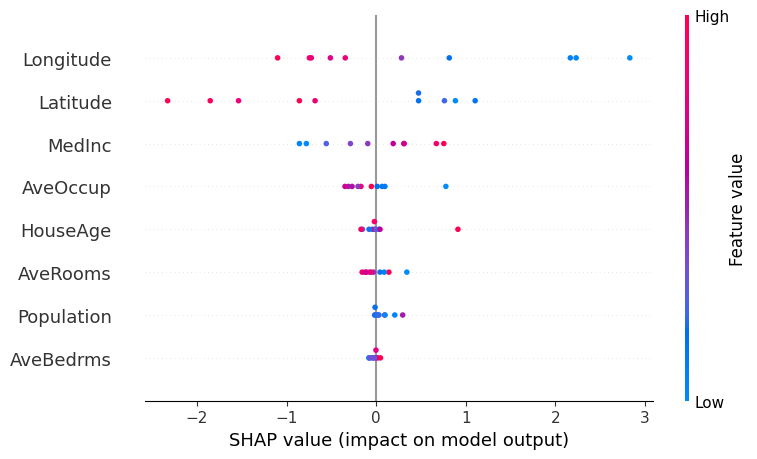

In [155]:
feature_names = train_x.columns.tolist()
shap.summary_plot(shap_values_squeezed, test_sample, feature_names=feature_names)

To interprete the graph:
a. Each dot represents a datapoint,

b. Each row on the y-axis is a feature,

c. The x-axis is the shap value which is how much the feature up or down the prediction for that data point.

d. Left (negative values): Decreased the prediction

e. Right (positive values): increased the prediction

f. Red: The feature had a high value at that data point

g. Blue: The feature had a low value at that data point

SHAP orders the features according to the most important as seen above, so, the most important features were:

a. Longitude: From the graph above, we can see that higher longitude values tend to lower the predicted house price. The longitude is generally for the eastern and western locations in California, and higher longitude values are generally towards the east. So, for housing in the east, housing prices are predicted to be lowered.

b. Latitude: Similarly for the longitude, the latitude also shows that higher latitude values, decrease predicted housing prices. The latitude is generally for the nothern and southern locations, and higher latitude values are generally towards the north. So, hor housing in this are, prices are predicted to be cheaper.

c. MedInc: this refers to median income and it shows that the higher the medinc, the higher the predicted housing price.

The model relies on both location and median income to predict income prices. The features where the dots are close to the line indicate that they do not influence the model as much